### Description   

    Old versions of SR-LAB-Startle Response Systems were isolating by default the wave with the highest peak (Vmax). However, some startle responses display two consecutive waves where the first one is of lower scale than the second. In such cases, the user had to manually set the start & end point for every single trial if (s)he was interested in isolating the initial responses to the auditori stimulus. This script solves this problem by detecting cases in which an initial response occurs before the largest response. Depending on whether an initial lower - yet significant - response exists or not, the final output for the respective trial will contain different T & V values or not, respectively. 
    
    Filtering is also applied in cases where all responses of a trial for a mouse are very low as well as for cases where peaks are displayed too early or too late to be deemed as responses related to the stimulus.
    
    Criteria for filtering, namely minimum V value, T value, height, prominence, threshold and distance of peaks can be changed by the user accordingly.
    
    The raw data derived from recordings of 4 boxes are required. Yet the user can modify the script if the raw data includes information from more or less than 4 boxes.

### Example of a dataset with V responses per ms in a bNgN.csv file, where N is a batch and group number.

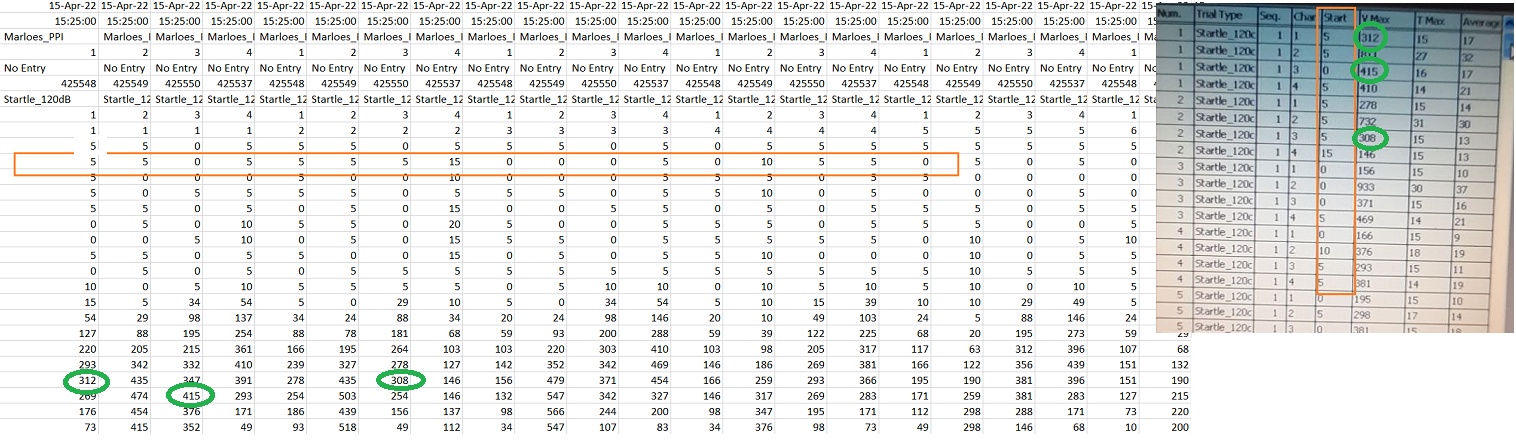

### Example of a primary, lower peak that replaces the highest peak

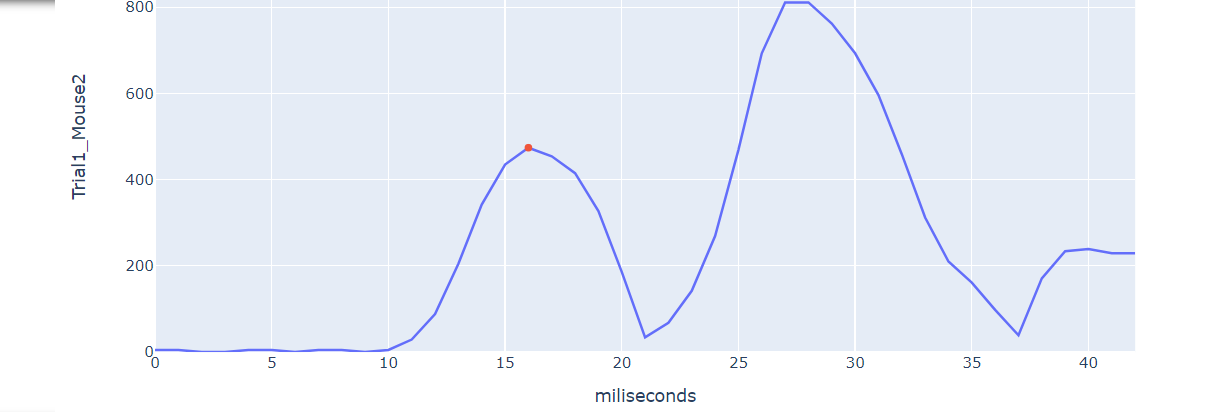

### 2024 Update for project 2021-0005-008   : Instead of selecting the Tmax of the initial peak, we now select the timepoint of the starting edge before the initial peak. In the Image above, this would be time point 11

#### Below a description of the main convertions that take place :

Taking into account that we are always using 4 SR-LAB boxes :



1) ColumNames() will replace the columns' names in the raw file of Startle with 

    Trial1_Mouse1 Trial1_Mouse2 Trial1_Mouse3 Trial1_Mouse4 Trial2_Mouse1 Trial2_Mouse2 ... and so on.

   For instance, the first 3 rows in the raw data file :

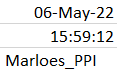

   will become...  

     Trial1_Mouse1       Trial1_Mouse2   Trial1_Mouse3 Trial1_Mouse4 
     0      14:57:29      14:57:29         14:57:29         14:57:29         
     1   Marloes_PPI     Marloes_PPI     Marloes_PPI     Marloes_PPI  



2) 
    Find_Maxima_And_Exclude() will trace the highest peak and save the respective V and T value. It will also exclude trials 
    wherein the highest peak is below the cutoff criterion. The output of Find_Maxima_And_Exclude will be two dictionaries. One 
    dictionary contains the maximum V value of each trial (Vmax) and another one the T value of each trial (Tmax). Therefore, V 
    max dictionary will be like this :

    {'Trial1_Mouse1': 73, 'Trial1_Mouse2': 49, 'Trial1_Mouse3': 371, 'Trial1_Mouse4': 1104, 'Trial2_Mouse1': 151, 'Trial2_Mouse2': 327, ... and so on ... }

    Similarly, Tmax dic will be like this :
    
    {'Trial1_Mouse1': 16, 'Trial1_Mouse2': 30, 'Trial1_Mouse3': 15, 'Trial1_Mouse4': 26, 'Trial2_Mouse1': 35, 'Trial2_Mouse2': 16,
   
   This function will also save all excluded trials to a dict, namely 'all_too_low'. The key of this dict will have the raw csv file's name as key and the specific trial as value (i.e. Trial10_Mouse4). Trials wherein no stimulus was present will be saved in another dictionary called 'no_stim_excl'. The key of this dict will have the raw csv file's name as key (i.e. b1g1.csv - which stands for Batch1Group1 and the specific trial as value (i.e. Trial11_Mouse1). Please note that every group has 4 animals in our case
   
3) ExcludeNoisyOnset() will help to further filter out trials wherein noteworthy motion was detected too early following stimulus onset. 
   If between 0 and 0+x miliseconds there is movement equal or higher than a V-value cutoff criterion at least y times, then the trial is added to exclusion list. Below an example of a trial that has been excluded (x=10, y=3, cutoff criterion =20) :
      

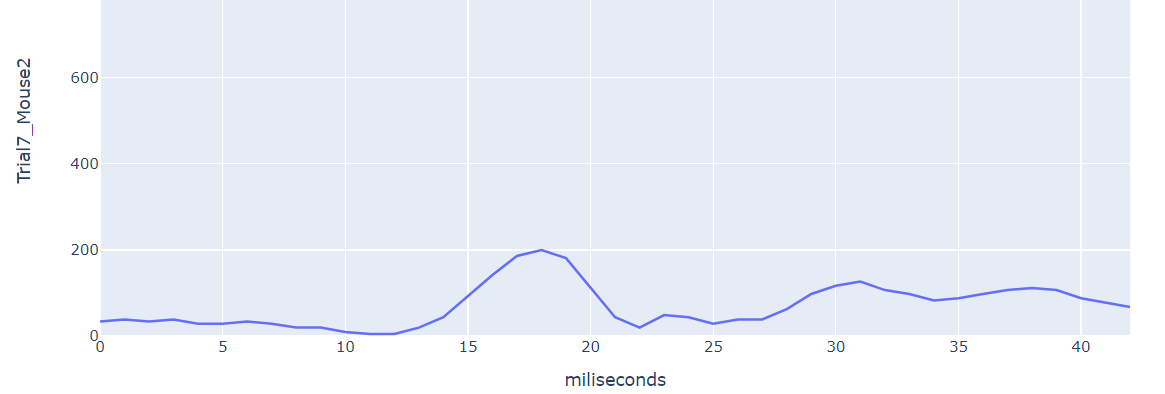

This trial will be saved in all_premature_resp dictionary. The key of this dict will be the raw csv file's name (i.e. b1g1.csv) and the value will be the specific trial  (i.e. Trial7_Mouse2). Of note, ExcludeNoisyOnset() won't remove these noisy onset trials directly. However, the all_premature_resp[b1g1.csv] will be later used as a filter itself to rule out noisy trials. Therefore, there is no output for this function.

4) FindPeaks() uses scipy find.peaks() method to apply further cutoff criteria and detect all peaks within an acceptable range.

There are several criteria, namely

        maximum response time -> the maximum time that a reaction can be deemed as stimulus-related
        minimum response time -> the minimum time that a reaction can be deemed as stimulus-related
        height                -> the V value of a peak
        distance              -> the minimum horizontal distance between two neighboring peaks (in terms of time).
                                 Smaller peaks are removed first until the condition is fulfilled for all remaining peaks.
        prominence            -> the distance of the peak from its relative baseline
        
FindPeaks() will skip the trials that have been tagged as excluded and solely look at the (so far) accepted ones. These correspond to the keys in Vmax and Tmax respectively. After detecting peaks based on height, distance and prominence, it will apply the time-window cutoff criteria and keep only the peaks that are between the maximum and minimum response time. Of note, no peak following the default Vmax will be registered, since we are not interested in what follow the default Vmax. It is the peaks that precede it that might we want to use as a replacement (see picture 1).
      
If none of the peaks left following height,distance and prominence filtering fall within the time-window criteria, then the whole trial will be excluded to a dictionary called 'all_time_or_peak_exclusions' - as in the previous exclusions dictionaries, the key of this dict will be the raw csv file's name (i.e. b1g1.csv) and the value will be the specific trial  (i.e. Trial7_Mouse2). Otherwise, out of all peaks that satisfy the set of criteria, the earliest one will be registered as the peak of interest. If this is not the default Vmax peak, then the latter will be replaced by the primary.

The output of FindPeaks can be considered as the final output. It is a dictionary with trial's names as keys and a list containing the V and T value of this trial, respectively. For example :
     
{'Trial1_Mouse1': [73, 10], 'Trial1_Mouse2': [44, 9], 'Trial1_Mouse3': [371, 11], 'Trial1_Mouse4': [747, 12], 'Trial2_Mouse1': [146, 10], 'Trial2_Mouse2': [327, 10], ... and so on and so forth...

Note that for this snippet - which has been upgraded for project 2021-0005-008 - the T value (i.e the 10 in [73,10] is not the value corresponding to the peak of interest anymore, but the timepoint of the starting edge of the waveform that peaks to the peak of interest.)

Keep in mind that the whole dictionary will be used as a value to the 'all_final_VT' dictionary that has the raw csv Startle file's name as key (i.e. b2g2). See this command in Main Code 'all_final_VT[file] = FindPeaks(df,Vmax,Tmax,file)'.

LocateStartOfPeak() identifies the starting edge of the waveform, which is included in the VTvalues in FindPeaks(). After it converts the df's series to array, it reverses the array and iterates across values, starting from the timepoint of the peak of interest and going backwards. If the stop_looking_left criterion is 20,  then the array starting from the peak of interest 267 [267,209,187,150,120,80,50,32,25,20,15,15,10,0,5] 
will return the position 6, which is the start of the waveform 
 

Finally, VerifyExclusions() will run to make sure that none of the filtered out trials is included to our final results.

In [32]:
import pandas as pd
import numpy as np
import statistics as st
from statistics import StatisticsError
import plotly.express as plt
import scipy
from scipy.signal import find_peaks
from decimal import Decimal as D
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
from scipy.signal import find_peaks, peak_widths
import re

In [ ]:
# row 8 in big_df is the 1st ms; every row corresponds to an ms. The column corresponds to vmax values

In [33]:
def ColumNames ():
    """No input needed
       Output : List with modified trial names as elements such as Trial3_Mouse4"""
    columnames = []
    Mouse_N = [1,2,3,4]*72
    Trial_N = ['Trial'+str(i) for i in range(1,73) for y in range (4)]
    for i in range (0,288):
        columnames.append(Trial_N[i]+'_Mouse'+str(Mouse_N[i]))
    return columnames

In [34]:
def Find_Maxima_And_Exclude (bigdf, file, cut_criterion=25):
    """ Input 1    : dataframe
        Input 2    : str indicating a particular file with Startle raw data within a directory
        Output 1   : dictionary with columns (trial names) as keys and Vmax as values
        Output 2   : dictionary with columns (trial names) as keys and Tmax as values
        
        
        Description : 
        1) Calculate Vmax and Tmax for each trial
        2) save 'no stimulus' trials in an exclusion list
        3) add low vmax trials (<cut_criterion) derived from stimulus-on conditions in another exclusion list"""
    
    Vmax_dic = {}
    Tmax_dic = {}

    # the numbers are by default strings; Here we change them to int
    for column in bigdf.columns :
        bigdf[column][6:-1] = bigdf[column][6:-1].astype(int)
        # then we find the V max of every column, always searching from row 8 onwards since that's the stimulus onset
        highest= bigdf[column][8:-1].max()
        # and we create Vmax_dic[column] = Vmax in all conditions where auditory stimulus was present
        # in case it was a stimulus-off trial we move to step 2 of the description
        if bigdf[column].iloc[5] != ' No_stimulus' :
            # this is step 3 of the description. Low vmax values will be converted to nan
            if highest <= cut_criterion :
                # if the vmax was lower than cut_criterion, then we save the column's name to a specific exclusion list
                all_too_low[file].append(column)
            else :    
                Vmax_dic[column] = highest
            # and then we create Tmax_dic[column] = Tmax; we subtract the index where the Vmax is by 8 because the first 0-7 rows are not real ms
                Tmax_dic[column] = (bigdf[bigdf[column] == highest].index[0]) - 8 
            # if it was a no stimulus trial, then we save its name to another exclusion list
        else :
            no_stim_excl[file].append(column)
            
    return Vmax_dic,Tmax_dic

In [35]:
def ExcludeNoisyOnset (df,file,cutms=8,cutsize=20,cutcounter=3):
    """Input 1: short dataframe
       Input 2: str indicating a particular file with Startle raw data within a directory
       Input 3: int 
       Input 4: int 
       Input 5: int
       
       Locates and excludes trials wherein noteworthy motion was detected too early following stimulus onset.
       Criterion : if between 0 and 0+cutms miliseconds there is movement equal or higher than cutsize (V value) at least 
       cutcounter times, then the trial is added to exclusion list"""
 
    # -1 to get rid of 'miliseconds' column
    all_columns = df.columns[:-1]
    for column_index in range(len(all_columns)):
        curr_trial = all_columns[column_index]
        if (curr_trial in no_stim_excl[file]) or (curr_trial in all_too_low[file]) :
            continue
        else :
            # another criterion could be if any response in this window is 25 or more
            counter = 0
            # remember that 8 corresponds to 0 ms
            for point in list(df[curr_trial][8:8+cutms]) :
                if point >= cutsize :
                    counter += 1
                    if counter > cutcounter :
                        all_premature_resp[file].append(curr_trial)
                        break  

### The stop_looking_left must be in accordance (or at least very close) to the cutsize in ExcludeNoisyOnset()

In [36]:
def LocateStartOfPeak(daframe, peakpoint,trialN,stop_looking_left):
    """
    Input daframe           : short dataframe
    Input peakpoint         : int indicating the time point of the unique peak of intereste that has been selected by FindPeaks()
    Input trialN            : str indicating the current trial, as defind in FindPeaks()
    Input stop_looking left : int indicating a value, lower of which we do not consider any point as part of startle response. 
       Locates the starting edge of the incline of the detected peak. To achive this, the series of a short df is converted to array first.
       This array is then reversed and we start looking from the peak towards the left (past) until we come across a value that is lower than the
        stop_looking_left int. """
    
    vvalues = np.array(daframe[trialN][8:peakpoint+8])

    for i in range(len(vvalues[::-1])):
        identified = False
        valueee = vvalues[::-1][i]
        if valueee < 20 :
            identified = True
            positione = len(vvalues) - i
            return positione
    if identified == False :
        print(f"WARNING : The start of a peak in {trialN} of {file} could not be identified !")


## Make sure that height equals cut_criterion. Mind that prominence cut-off will eliminate some peaks that surpass the height criterion

In [37]:
def FindPeaks(df, Vmax_dic, Tmax_dic, file, max_resp_time =25,min_resp_time = 5,height=25,distance=3,prominence=40,stopleft=20):
    """ Input 1: Short dataframe (better ~50 rows instead of default 508)
        Input 2: Dict with str (trials) as keys and int representing V max value as value
        Input 3: Dict with str (trials) as keys and int representing T max value as value
        Input 4: str indicating a particular file with Startle raw data within a directory
        Input 5: int representing a filtering criterion. Responses above it will be deemed as too slow to be relevant
        Input 6: int representing a filtering criterion. Responses below will be deemed as too fast to be relevant
        Input 7: int representing height criterion for peak
        Input 8: int representing required minimal horizontal distancein samples between neighbouring peaks. Smaller peaks are removed first until the condition is fulfilled for all remaining peaks.
        Input 9: int representing prominence criterion for peak distance of peak from start of its ascend.
        Input 10:int indicating indicating a value, lower of which we do not consider any point as part of startle response. See LocateStartOfPeak()

        Output 1: Dict with Trial names as keys (str) and list with V value and T value (int) as value.
        Non-returned, global output : peak and time exclusion trials are appended as single elements to a list*. 
        This list is a value of a dict that has the filename as key. Hence, there are as many keys as many raw data files.
        *Similarly for all_many_peaks, all_too_low and all_premature responses. Note that all_many_peaks are included in 
        final_VT_values
        
        1)Finds ALL peaks in an acceptable time range following stimulus presence, including default Tmax
          And finally Returns the Vmax and T max of the corrected peak (first of significant ones for each trial) when a correction is needed.
          Otherwise returns the default Vmax and Tmax, provided that Vmax and Tmax satisfy peak-criteria and time-related criteria.
        2)Finds trials COMPLETELY devoid of acceptable responses based on peak and time window criteria"""
    
    VTvalues = {}
    all_columns = df.columns[:-1] # -1 to get rid of 'miliseconds' column

    for column_index in range(len(all_columns)):  #trials that have been tagged as excluded will be skipped
        curr_trial = all_columns[column_index]
        if (curr_trial in no_stim_excl[file]) or (curr_trial in all_too_low[file]) or (curr_trial in all_premature_resp[file]) :  # if none of the peaks satisfies peak or time-window criteria, the trial will be added to an exclusion list
            continue
        
        peaks, peakinfo = find_peaks(list(df[curr_trial][8:]), height=height, distance=distance, prominence=prominence)  # peaks, to display the result of peaks and not the rest of the info given by the method; ## peakinfo is for find_peaks()[1];### parameters like height, threshold,distance and prominence are very important for defining a peak; ## Note that 8 is the row when the 0ms start, the previous rows are other info like channel etc; 
        timed_peaks = []                                                                                # this is an extra step of filtering where peaks emerging below x ms will be excluded ; ## peaks above y ms will also be excluded deemed as too delayed responses to be relevant to stimulus. 
        for peak in peaks :
            if max_resp_time >= peak >= min_resp_time :
                timed_peaks.append(peak)
                if peak == Tmax[curr_trial] :
                    timed_peaks.append(peak)
                    break                                                                               # by using this break we make sure that there will be no more peaks following the default Tmax
        
        if timed_peaks == []:                                                                           # if none of the peaks satisfies both peak and time-window criteria then exclude the trial
            all_time_or_peak_exclusions[file].append (curr_trial)
            continue

        elif timed_peaks[0] == Tmax_dic[curr_trial]:                                                    # if the only peak that satifsies the peak criteria is the default T max. Note that Tmax can only be the last peak in a list. Hence, if 1st it means there are no others
            newstart =  LocateStartOfPeak(df, timed_peaks[0],curr_trial,stopleft)                       # identify that starting edge of the peak
            VTvalues[curr_trial] = [Vmax_dic[curr_trial],newstart]                          
        elif len(timed_peaks) == 2 :                                                                    # if there are two peaks that satisfy criteria take the Vmax and Tmax of the earliest; 
            newstart =  LocateStartOfPeak(df, timed_peaks[0],curr_trial,stopleft)
            VTvalues[curr_trial] = [df[curr_trial].loc[timed_peaks[0]+8],newstart]     
        else :
            newstart =  LocateStartOfPeak(df, timed_peaks[0],curr_trial,stopleft)                       
            VTvalues[curr_trial] = [df[curr_trial].loc[timed_peaks[0]+8],newstart]
            all_many_peaks[file].append(curr_trial)
            
    return VTvalues

# Note that if I decide to change Tmax in the future in cases of almost equal neighboring peaks (like 15.5ms instead of 16), the new Tmax has to be named differently because Tmax is used for comparisons here

In [38]:
def VerifyExclusions (all_final_VT,file) :
    """Input 1: dict with raw data file names as keys (str) and dict with trial names (str) as VALUES, which have 
                the definite V & T max as values of their own
       Input 2: str indicating a particular file with Startle raw data within a directory """
    global no_stim_excl
    global all_too_low
    global all_premature_resp
    
    counter = 0 
    for trial in all_final_VT[file] :
        if (trial in no_stim_excl[file]) or (trial in all_too_low[file]) or (trial in all_premature_resp[file]):
            print('Error detected. Some excluded trials have not been filtered out')
            counter += 1
        else: 
            pass
    if counter == 0 :
        print ("All filtering criteria have been applied successfully. For more information run DisplayTrials()")

## Main Code

In [39]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
path = r'C:\Users\angdid\Desktop\rawdata'
files = [f for f in listdir(path) if isfile(join(path, f))]
all_final_VT = {} # The final output containing V & Tmax values from all raw data following all filters in a folder
all_too_low = {}  # Excluded trials from all raw data in a folder where the default Vmax was below minimum criteria 
all_time_or_peak_exclusions = {}  # Excluded trials from all raw data in a folder where not even one peak met peak or time-window criteria
all_dfs = {} 
all_many_peaks = {}
all_premature_resp = {}
no_stim_excl = {} 

for file in files :
    print(file)
    big_df = pd.read_csv(join(path,file))

     # - - - - - - -  R E P L A C E M E N T S   F O R   P R O J E C T 2 - - - - - - - 
    big_df.iloc[5] = big_df.iloc[5].apply(lambda x: x.replace("_thibault", ""))      # After Thibault recreated it, an extra _thibault was added to the name. We take it out.
    big_df.iloc[5] = big_df.iloc[5].apply(lambda x: x.replace("Stimulus", "stimulus"))      # After Thibault recreated it, an extra _thibault was added to the name. We take it out.
    # - - - - - - -     D O N E - - - - - - - 

    
    big_df.columns = ColumNames()
    #print('filename is {f} and boxes arrangement is {b}'.format(f=file, b = big_df.iloc[0:7,0:4]))
    # See filter description
    all_many_peaks[file]= []
    all_too_low[file] = []
    all_time_or_peak_exclusions[file] =[]
    all_premature_resp[file]=[]
    no_stim_excl[file] = []
    
    # Default Vmax and Tmax except fore the cases where no stimulus is present or Vmax is too low (see parameters)
    Vmax,Tmax = Find_Maxima_And_Exclude(big_df,file)
    # a deepcopy is needed to avoid error ; also narrow down data from responses to first 50 (-8) responses
    ## there is a small chance that late Vmax/Tmax responses will be excluded during this cut. This is expected though.
    df = big_df.copy(deep = True).loc[0:50]
    all_dfs[file] = df
    # If there is noteworthy response preceding stimulus onset, remove trial (see function for details)
    ExcludeNoisyOnset(df,file)
  
    # a column with miliseconds will be added, first 8 rows are not miliseconds but it helps to set in that way
    df['miliseconds']  = [i for i in range(-8,43)]
    # add the dictionary with filtered in trials as keys and Vmax/Tmax list as value to a larger dictionary
    all_final_VT[file] = FindPeaks(df,Vmax,Tmax,file)
    # in case some exclusion has -for whatev
VerifyExclusions (all_final_VT,file)



b10g1.csv
b10g2.csv
b10g3.csv
b10g4.csv
b11g1.csv
b11g2.csv
b11g3.csv
b11g4.csv
b2g1.csv
b2g2.csv
b2g3.csv
b2g4.csv
b4g1.csv
b4g2.csv
b4g3.csv
b4g4.csv
b5g1.csv
b5g2.csv
b5g3.csv
b5g4.csv
b6g1.csv
b6g2.csv
b6g3.csv
b6g4.csv
b7g1.csv
b7g2.csv
b7g3.csv
b7g4.csv
b8g1.csv
b8g2.csv
b8g3.csv
b8g4.csv
b9g1.csv
b9g2.csv
b9g3.csv
b9g4.csv
All filtering criteria have been applied successfully. For more information run DisplayTrials()


# Create excel with final values  for statistical analysis 

Trials of 120dB do not include pre-pulse. We use them to calculate the reaction to the stimulus per se (control). However, we don't take into all 120db trials in our experiment. Only some of them ( the "sandwiched" ones ) These are the trials 7,16..66 as indicated in list "sandwiched" below. 

In [ ]:
# an expected mistake here is same mouse id in different trials because the user hasnt changed it on Startle

In [40]:
def IDLocation (big_df):
    """Input : big dataframe (without excluded trials)
       Output: int indicating the row wherein the mouse id is in the raw data file
       
       For some reason, sometimes the mouse IDs are in different columns in Startle's raw data files.
       Could be because there is a Subject and an ID column. And I was usually using the Subject columns to write IDs.
       This is to locate the right row provided that mouse id has 6 digits"""
    
    for y in range(6):
        lista = (list(big_df[big_df.columns[0:4]].iloc[y])) #Look at 6 first rows of first 4 col, not only 1st col, because 1st might be No entry
        for i in lista:
            try :
                int(i)
                if re.findall(r'\d{6}',i):
                    return y
            except:
                pass

In [41]:
def GleandB (FinalVT,file,sandwiched,N_animals=4,value=1) :
    """ 
       Input 1: Dict with trials (str) as keys and list with [V value, T value] as value. These are the final, filtered values
       Input 1 example : {'Trial1_Mouse1': [312, 15],
                          'Trial1_Mouse2': [474, 16],
                          'Trial1_Mouse3': [415, 16],
                          'Trial1_Mouse4': [410, 14],
                          'Trial2_Mouse1': [278, 15],
                          ... etc ...
       Input 2: str indicating a particular file with Startle raw data within a directory
       Input 3: list with 120dB trials (indicating points in an experiment's trial sequence) that we are interested in
       Input 4: int representing the number of animals in an experiment (normally we use all 4 boxes).
       Input 5: int representing an index in each list (each of these lists is a value to one of the FinalVT keys). 
                If set to 0, then V value will be extracted instead of T.
       
       
       Output : Dict -> Keys: str representing real mouse id
                        Values: Dict -> keys: dB conditions (str) 
                                        value: list with all T (or V, depending on input 5) values observed for each dB condition
                                        
       Output example : {'  423952': {'Startle_120dB': [14, 14, 14, 15, 14, 15, 14, 14, 14, 14, 14, 14], 
                                       'PPI_85dB': [16, 15, 15, 16, 16, 14, 15, 14, 14, 14], 
                                       'PPI_80dB': [15, 15, 15, 15, 15, 14, 15, 14], 
                                       'PPI_75dB': [14, 15, 15, 14, 14, 15, 16, 14, 16, 15]}, '  
                            423456': ... etc ...
      
      Non-returned output : appending real mouse ids (as values) to a dict with numbers corresponding to boxes as keys
      
      This function does nothing more than rearranging already existent information. See Input1 and Output example """
    
    curr_df = all_dfs[file]               # isolate the dataframe of interest
    id_row = IDLocation(all_dfs[file])    # locate the row where the ID is 
    boxid = [(f'Mouse{curr_df[column].loc[6]}',curr_df[column].loc[id_row]) for column in curr_df[curr_df.columns[8:12]]] #6th row always contains the boxnumber and by default box 1 corresponds to Mouse1. Id row can vary but it contains the real id. Here, we create (boxnumber, real id) 

    # Mouse1 means mouse in box 1 and so on...
    
    dB = { 'Mouse1' : {'Startle_120dB': [] , 'PPI_85dB' : [] , 'PPI_80dB' : [], 'PPI_75dB' : [] },
           'Mouse2' : {'Startle_120dB': [] , 'PPI_85dB' : [] , 'PPI_80dB' : [], 'PPI_75dB' : [] }, 
           'Mouse3' : {'Startle_120dB': [] , 'PPI_85dB' : [] , 'PPI_80dB' : [], 'PPI_75dB' : [] },
           'Mouse4' : {'Startle_120dB': [] , 'PPI_85dB' : [] , 'PPI_80dB' : [], 'PPI_75dB' : [] }
         }
    
    for trial in FinalVT:  
        condition = df[trial].loc[5]  # Can be either No stimulus or x_dB, located always at 5th row in the dataframe
        mouse_number = trial.split('_')[1]    # for instance, isolate Mouse3 from 'Trial1_Mouse3'
        valdB = re.findall('\d+', condition)[0] # For unknown reason, raw data have either one or two whitespaces before condition itself
        ppiORstartle = condition.split('_')[0].strip()    #for instance, isolate 'PPI' from ' PPI_85dB' or '  PPI_85dB'
        stimtype = f'{ppiORstartle}_{valdB}dB' # note that str has been stripped. Thus there is no whitespace in the beginning
        if ('Startle' in stimtype) and (df[trial].loc[7] not in sandwiched): # if there is a 120dB condition but is not in the ones we study
            pass
        else :
            dB[mouse_number][stimtype].append(FinalVT[trial][value]) 
    
    # Now we want to change Mouse1,Mouse2... to real id names. We'll use boxid which is a list with [MouseN,realid], where N is a number from 1 to 4
    
    for cageN,real_id in boxid:
        dB[real_id] = dB.pop(cageN)                      #pop the key with its value and create a new mouse ID key with this key and value
        cage_and_mouse[int(cageN[-1])].append(real_id)   #note that if there were more than 9 boxes, regex should be used instead of -1
        
    return dB

In [42]:
def MixandMean (dB,output_df) :
    """Input 1: Dict -> Keys: str representing real mouse id
                        Values: Dict -> keys: dB conditions (str) 
                                        values: list with all V (or T) values observed for each condition
                For more clarity see the Output exampled of GleandB()
                
       Input 2: empty df with real ids as columns and ['120dB', '75-85dB','Trials PPI','Trials Non PPI','Box'] as indices
       Output : filled df with real ids as columns and ['120dB', '75-85dB','Trials PPI','Trials Non PPI','Box'] as indices"""
    
    for mouse in dB.keys() :
        PPlen = len (dB[mouse]['PPI_85dB']) + len (dB[mouse]['PPI_80dB']) + len (dB[mouse]['PPI_75dB'])
        PPsum = sum (dB[mouse]['PPI_85dB']) + sum (dB[mouse]['PPI_80dB']) + sum (dB[mouse]['PPI_75dB'])
        try :
            PPAvg = round (PPsum / PPlen, ndigits=2)
            NoPPAvg = round (st.mean(map(float,dB[mouse]['Startle_120dB'])), ndigits=2)
        except (StatisticsError,ZeroDivisionError) as e:
            excluded_mice.append(mouse) #in case of absence of values
            continue
          
        output_df[mouse]['120dB'] = NoPPAvg
        output_df[mouse]['75-85dB'] = PPAvg
        output_df[mouse]['Trials PPI']= PPlen
        output_df[mouse]['Trials Non PPI']= len(dB[mouse]['Startle_120dB'])
    
    return output_df

In [43]:
def ExcludeFewTrials () :
    """Excludes animals where only few trials were filtered in (Excel is a dataframe and will eventually become the output to excel)"""
    for ID in excel.columns:
        if excel[ID][2] > 13 and excel[ID][3] > 4 :
            pass
        else:
            print('Low number of values for mouse {mouse}. This will not be included in final excel file'.format(mouse=excel[ID].name))
            print('In more detail, for the PPI, there were {n} accepted and for the 120 {m} accepted'.format(n=excel[ID][2], m=excel[ID][3]))
            print('\n')
            excluded_mice.append(excel[ID].name)
            del excel[ID]

In [44]:
all_file_ids = []
sandwiched = [7,16,19,23,27,33,38,45,47,54,59,66]
excluded_mice = []
excel = pd.DataFrame(index = ['120dB', '75-85dB','Trials PPI','Trials Non PPI','Box'])
cage_and_mouse = {1:[],2:[],3:[],4:[]}    # real mouse ids will be appended here in GleandB()

for file in files: 
    dB = GleandB(all_final_VT[file],file,sandwiched,value=1) # insert value=0 for Vmax
    output_df = pd.DataFrame(columns = dB.keys(), index = ['120dB', '75-85dB','Trials PPI','Trials Non PPI','Box'] )
    output_df = MixandMean(dB,output_df)
#     display(output_df)
    for column in output_df.columns :
        if 'Entry' not in column:
            excel[column]= output_df[column]
            all_file_ids.append(column.strip())

for key,value in cage_and_mouse.items():
    value = [ident for ident in value if "Entry" not in ident]
    cage_and_mouse[key] = value
    
for col_id_str in excel.columns:
    for dic_index in range(1,len(cage_and_mouse)+1) :               # that should just be 4 when using 4 boxes
        if col_id_str in cage_and_mouse[dic_index]:
            excel[col_id_str].loc['Box'] = dic_index

ExcludeFewTrials() # excludes mice where at least half of the trials were already filtered out, either for PPI or Non PPI
excel = excel.T  #transpose
excel.to_excel ('C:\\Users\\angdid\\Desktop\\Rtest.xlsx')

#can add a code to test for same ids in different files

Low number of values for mouse   000000. This will not be included in final excel file
In more detail, for the PPI, there were nan accepted and for the 120 nan accepted


Low number of values for mouse   454629. This will not be included in final excel file
In more detail, for the PPI, there were 11 accepted and for the 120 7 accepted


Low number of values for mouse   445355. This will not be included in final excel file
In more detail, for the PPI, there were 8 accepted and for the 120 9 accepted


Low number of values for mouse   447906. This will not be included in final excel file
In more detail, for the PPI, there were nan accepted and for the 120 nan accepted


Low number of values for mouse   448517. This will not be included in final excel file
In more detail, for the PPI, there were 9 accepted and for the 120 4 accepted


Low number of values for mouse   448535. This will not be included in final excel file
In more detail, for the PPI, there were 7 accepted and for the 120 1 

# Display trials of interest

##### This is to check whether the current parameters give the desired results 

In [ ]:
def DisplayTrials() :

    file = input ('Type the name of a file name and press enter. For instance : b1g2.csv   ')        
    try :
        df = all_dfs[file]
        print('\n\n')
    except :
        print(file, "is not a right name. Please run the cell again")
        return

    print ('List with available options for display : \n\n', 'all_final_VT  (these are the final accepted trials after filtering) \n', 'all_too_low\n', 'all_time_or_peak_exclusions\n','all_premature_resp\n','no_stim_excl\n','all_many_peaks\n\n\n')        
    category = input ('Type the kind of trial you want to investigate from the above list. For instance: all_final_VT  ')
    try :
        eval(category)[file]
    except :
        print('\n\n Hello friend, Hello friend. You misstyped something :(  Please rerun the cell ! ')
        return
    
    df = all_dfs[file]
    FVT = eval(category)[file]
    space = " "

    for trial in FVT :
        condition = df[trial].loc[5]
        fig = plt.line(df.loc[8:], y=trial, x='miliseconds', title=f'{file}{40*space}{condition}')
        fig.update_layout(yaxis_range=[0,1000])
        if category == 'all_final_VT':
            obj_markers = go.Scatter(
                y = [FVT[trial][0]],
                x = [FVT[trial][1]],
                mode = 'markers',
                name = 'peak start'
                )
            fig.add_trace(obj_markers)

        fig.show()


In [ ]:
DisplayTrials()